# Final Data Science Project: Predicting MLB OPS from 2023 Player Stats

## By: Kent Morris, Eli Zublin, Kobe Deutscher, Zach Babbs

## Section 1: Data Importing and Preprocessing (100 Points)

In this section, we will:
- Import and explore the dataset
- Identify data types and dimensions
- Clean and handle missing data
- Transform and normalize skewed variables
- Remove outliers
- Create useful derived features


In [171]:
import sys
print(sys.executable)

import pandas as pd

pd.set_option("display.max_columns", None)
import warnings

import branca
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from branca.element import Figure
from folium import Marker
from folium.plugins import HeatMap
from scipy.special import boxcox1p
from scipy.stats import norm, probplot, skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline


/opt/anaconda3/bin/python


In [172]:
# Load dataset
dfMLB = pd.read_csv("2023MLBBattingStats.csv", encoding='latin1', sep=';')


In [173]:
#check number of rows and columns
dfMLB.shape

(695, 29)

In [174]:
cat_count = 0
for dtype in dfMLB.dtypes:
    if dtype == "object":
        cat_count = cat_count + 1

print("# of categorical variables:", cat_count)

numeric_vars = dfMLB.shape[1] - cat_count - 1
print(
    "# of contineous variables:", numeric_vars
)  # subtract and extra column as 1 column is an ID column

# of categorical variables: 3
# of contineous variables: 25


In [175]:
dfMLB.head()

Rk                  Name  Age   Tm  Lg   G   PA   AB   R    H  2B  3B  HR  \
0   1          CJï¿½Abrams*   22  WSN  NL  89  340  316  47   82  17   4  10   
1   2           Josï¿½Abreu   36  HOU  AL  95  400  368  33   90  16   0   8   
2   3  Ronaldï¿½Acunaï¿½Jr.   25  ATL  NL  97  446  391  86  129  26   1  23   
3   4        Willyï¿½Adames   27  MIL  NL  89  383  336  44   71  16   0  17   
4   5         Rileyï¿½Adams   27  WSN  NL  23   87   79   4   22   5   2   3   

   RBI  SB  CS  BB  SO     BA    OBP    SLG    OPS  OPS+   TB  GDP  HBP  SH  \
0   39  19   2  13  72  0.259  0.306  0.434  0.739   105  137    5    8   3   
1   50   0   1  24  92  0.245  0.293  0.353  0.646    79  130   11    3   0   
2   58  45   7  49  53  0.330  0.408  0.578  0.986   160  226    7    4   0   
3   48   4   3  37  98  0.211  0.291  0.411  0.702    90  138    9    3   0   
4   10   0   0   6  26  0.278  0.337  0.506  0.844   133   40    4    1   1   

   SF  IBB  
0   0    0  
1   5    1  
2   2    2  
3   5    0  
4   0    0

In [176]:
# Drop the 'last_name, first_name' and rename 'player_id' to 'Id, rename 'on_base_plus_slg' to 'OPS'
dfMLB = dfMLB.drop(columns=["Rk"])
dfMLB = dfMLB.drop(columns=["Tm"])
dfMLB = dfMLB.drop(columns=["Lg"])

In [177]:
# check the column names
dfMLB.columns

Index(['Name', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB'],
      dtype='object')

In [178]:
# Remove spaces from column names
dfMLB.columns = [col.replace(" ", "") for col in dfMLB.columns]
dfMLB.Name = [col.replace("ï¿½", " ") for col in dfMLB.Name]
dfMLB.head()

Name  Age   G   PA   AB   R    H  2B  3B  HR  RBI  SB  CS  BB  \
0        CJ Abrams*   22  89  340  316  47   82  17   4  10   39  19   2  13   
1         Jos Abreu   36  95  400  368  33   90  16   0   8   50   0   1  24   
2  Ronald Acuna Jr.   25  97  446  391  86  129  26   1  23   58  45   7  49   
3      Willy Adames   27  89  383  336  44   71  16   0  17   48   4   3  37   
4       Riley Adams   27  23   87   79   4   22   5   2   3   10   0   0   6   

   SO     BA    OBP    SLG    OPS  OPS+   TB  GDP  HBP  SH  SF  IBB  
0  72  0.259  0.306  0.434  0.739   105  137    5    8   3   0    0  
1  92  0.245  0.293  0.353  0.646    79  130   11    3   0   5    1  
2  53  0.330  0.408  0.578  0.986   160  226    7    4   0   2    2  
3  98  0.211  0.291  0.411  0.702    90  138    9    3   0   5    0  
4  26  0.278  0.337  0.506  0.844   133   40    4    1   1   0    0

Handling Missing Data

In [179]:
# List of key columns where zero might be suspicious
key_metrics = ['OBP', 'SLG', 'OPS', 'BA', 'OPS+']

# Convert to numeric if needed
for col in key_metrics:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')

# Count zeros instead of NaNs
total_zeros = (dfMLB[key_metrics] == 0).sum().sort_values(ascending=False)
percent_zeros = ((dfMLB[key_metrics] == 0).sum() / len(dfMLB)).sort_values(ascending=False)

# Combine into a DataFrame
zero_data = pd.concat([total_zeros, percent_zeros], axis=1, keys=["Total Zeros", "Percent Zeros"])
zero_data.head(20)

Total Zeros  Percent Zeros
SLG           111       0.159712
BA            111       0.159712
OBP           103       0.148201
OPS           103       0.148201
OPS+           88       0.126619

In [180]:
# Convert rate columns to numeric and treat 0 as missing
rate_cols = ['OBP', 'SLG', 'OPS', 'BA', 'OPS+']
for col in rate_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')
    dfMLB[col] = dfMLB[col].replace(0, pd.NA)

In [181]:
# Drop rows with missing OPS (our prediction target)
dfMLB.dropna(subset=['OPS'], inplace=True)
dfMLB.shape

(592, 26)

In [182]:
# Fill remaining rate-based NaNs with median
for col in rate_cols:
    if dfMLB[col].isnull().sum() > 0:
        dfMLB[col].fillna(dfMLB[col].median(), inplace=True)

In [183]:
# Convert raw numeric columns and fill their NaNs
raw_cols = ['AB', 'PA', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'HBP', 'SF', 'TB', 'RBI', 'SB', 'CS', 'G']
for col in raw_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')
    if dfMLB[col].isnull().sum() > 0:
        dfMLB[col].fillna(dfMLB[col].median(), inplace=True)

In [184]:
# Final dataset info
print("✅ Cleaned dataset shape:", dfMLB.shape)
print("Remaining missing values:", dfMLB.isnull().sum().sum())

✅ Cleaned dataset shape: (592, 26)
Remaining missing values: 0


The Dataset Contains Duplicate Names from in season trades and acquisitions during the season to handle this we will first identify the duplicate names and aggregate those stats for each player and recaluculate OPS metrics

In [185]:
# Count occurrences of each name
name_counts = dfMLB['Name'].value_counts()

# Filter to only those names with more than one occurrence
duplicates = name_counts[name_counts > 1]

# Display the duplicate names and how many times each appears
print("Duplicate player names and their counts:")
print(duplicates)

Duplicate player names and their counts:
Name
Jake Marisnick      4
Aaron Hicks#        3
Darin Ruf           3
Eduardo Escobar#    3
Gary S nchez        3
Mike Moustakas*     3
Jorge Alfaro        3
Austin Wynns        3
Raimel Tapia*       3
Matt Beaty*         3
Tyler Heineman#     3
Carlos P rez        2
Name: count, dtype: int64


In [186]:
# 1. Identify which columns to aggregate: all numeric except 'Age'
numeric_cols = dfMLB.select_dtypes(include='number').columns.tolist()
agg_cols = [c for c in numeric_cols if c != 'Age']

# 2. Group by Name and sum all counting stats
df_agg = (
    dfMLB
      .groupby('Name', as_index=False)[agg_cols]
      .sum()
)

# 3. Recompute rate stats from the aggregated counts
df_agg['OBP'] = (
    df_agg['H'] + df_agg['BB'] + df_agg['HBP']
) / (
    df_agg['AB'] + df_agg['BB'] + df_agg['HBP'] + df_agg['SF']
)

df_agg['SLG'] = df_agg['TB'] / df_agg['AB']
df_agg['OPS'] = df_agg['OBP'] + df_agg['SLG']

#To preserve Age, you could take the max or first:
df_agg = df_agg.merge(
    dfMLB.groupby('Name', as_index=False)['Age'].max(),
    on='Name'
)

# 5. Replace your working DataFrame
dfMLB = df_agg.copy()

# 6. Verify duplicates are gone
dupes_after = dfMLB['Name'].value_counts()

# 7. Optional sanity check
print("Final shape:", dfMLB.shape)

Final shape: (568, 26)


### Handling Outliers

#### Target Variable

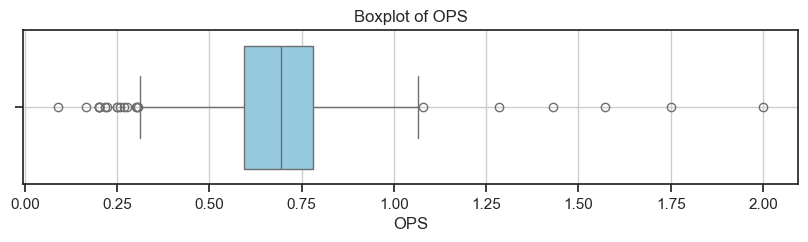

In [187]:

# Create boxplot of OPS Distrubution
plt.figure(figsize=(10, 2))
sns.boxplot(x=dfMLB['OPS'], color="skyblue")

# Customize plot
plt.title('Boxplot of OPS')
plt.xlabel('OPS')
plt.grid(True)
plt.show()

### Potential Outliers are if there are few At Bats Played resulting in a high or low OPS and Overall few at bats played by a player

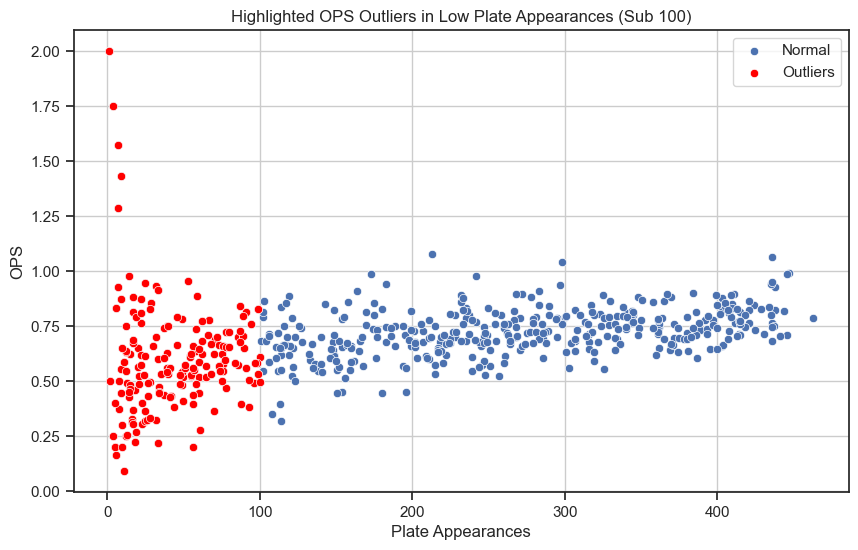

In [188]:
# Identify potential outliers: low games + extreme OPS
# Ensure G and OPS are numeric
dfMLB['PA'] = pd.to_numeric(dfMLB['PA'], errors='coerce')
dfMLB['OPS'] = pd.to_numeric(dfMLB['OPS'], errors='coerce')

# Drop rows with missing G or OPS
dfMLB = dfMLB[dfMLB['PA'].notna() & dfMLB['OPS'].notna()]

# Identify outliers: extreme OPS with few at bats played
outlier_candidates = dfMLB[(dfMLB['PA'] <= 100)]

# Plot all points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dfMLB, x='PA', y='OPS', label='Normal')

# Highlight outliers
sns.scatterplot(data=outlier_candidates, x='PA', y='OPS', color='red', label='Outliers')

# Customize plot
plt.title('Highlighted OPS Outliers in Low Plate Appearances (Sub 100)')
plt.xlabel('Plate Appearances')
plt.ylabel('OPS')
plt.legend()
plt.grid(True)
plt.show()

In [189]:
# Ensure 'G' and 'OPS' are numeric
dfMLB['PA'] = pd.to_numeric(dfMLB['PA'], errors='coerce')
dfMLB['OPS'] = pd.to_numeric(dfMLB['OPS'], errors='coerce')

# Drop rows with missing values in those columns
dfMLB = dfMLB[dfMLB['PA'].notna() & dfMLB['OPS'].notna()]

# Create a Boolean mask for the outliers
outlier_mask = (dfMLB['PA'] <= 100)

# Apply the inverse of the mask to filter them out
dfMLB_cleaned = dfMLB[~outlier_mask]

# Show results
print("Original shape:", dfMLB.shape)
print("Cleaned shape:", dfMLB_cleaned.shape)
print("Removed rows:", dfMLB.shape[0] - dfMLB_cleaned.shape[0])

# Overwrite dfMLB if desired
dfMLB = dfMLB_cleaned



Original shape: (568, 26)
Cleaned shape: (389, 26)
Removed rows: 179


### Normalize Target Variable
Normalizing the target variable is important for linear model performance. It does not have an impact for tree models, thus it is best practice to do so for preprocessing.

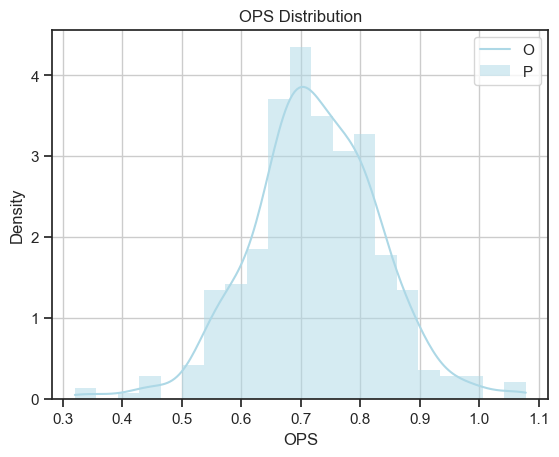

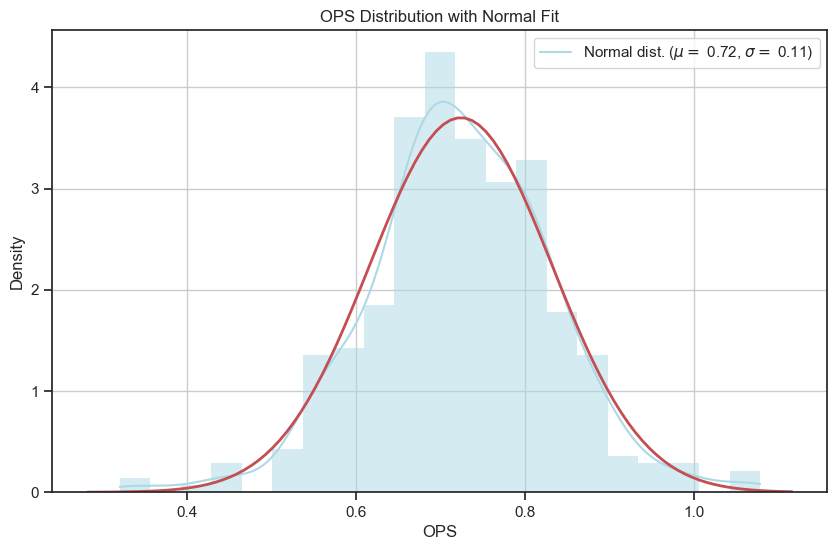

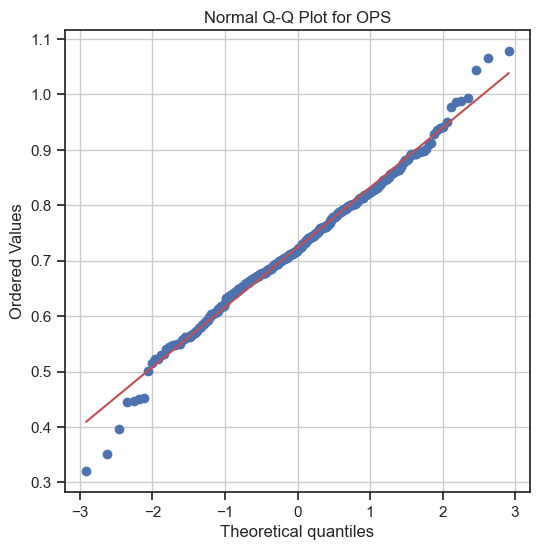

In [190]:
# Distribution before Normalization
sns.histplot(dfMLB["OPS"], kde=True, stat="density", linewidth=0, color="lightblue")

plt.legend("OPS Distribution", loc="best")
plt.xlabel("OPS")
plt.ylabel("Density")
plt.title("OPS Distribution")
plt.grid(True)
plt.show()

#Plot histogram with normal fit
plt.figure(figsize=(10, 6))
sns.histplot(dfMLB["OPS"], kde=True, stat="density", linewidth=0, color="lightblue")

# Fit normal distribution to OPS
mu, sigma = norm.fit(dfMLB["OPS"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

# Labels and legend
plt.legend([r"Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], loc="best")
plt.xlabel("OPS")
plt.ylabel("Density")
plt.title("OPS Distribution with Normal Fit")
plt.grid(True)
plt.show()

# Q-Q plot for OPS
plt.figure(figsize=(6, 6))
probplot(dfMLB["OPS"], dist="norm", plot=plt)
plt.title("Normal Q-Q Plot for OPS")
plt.grid(True)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

Target Variable Scatterplots

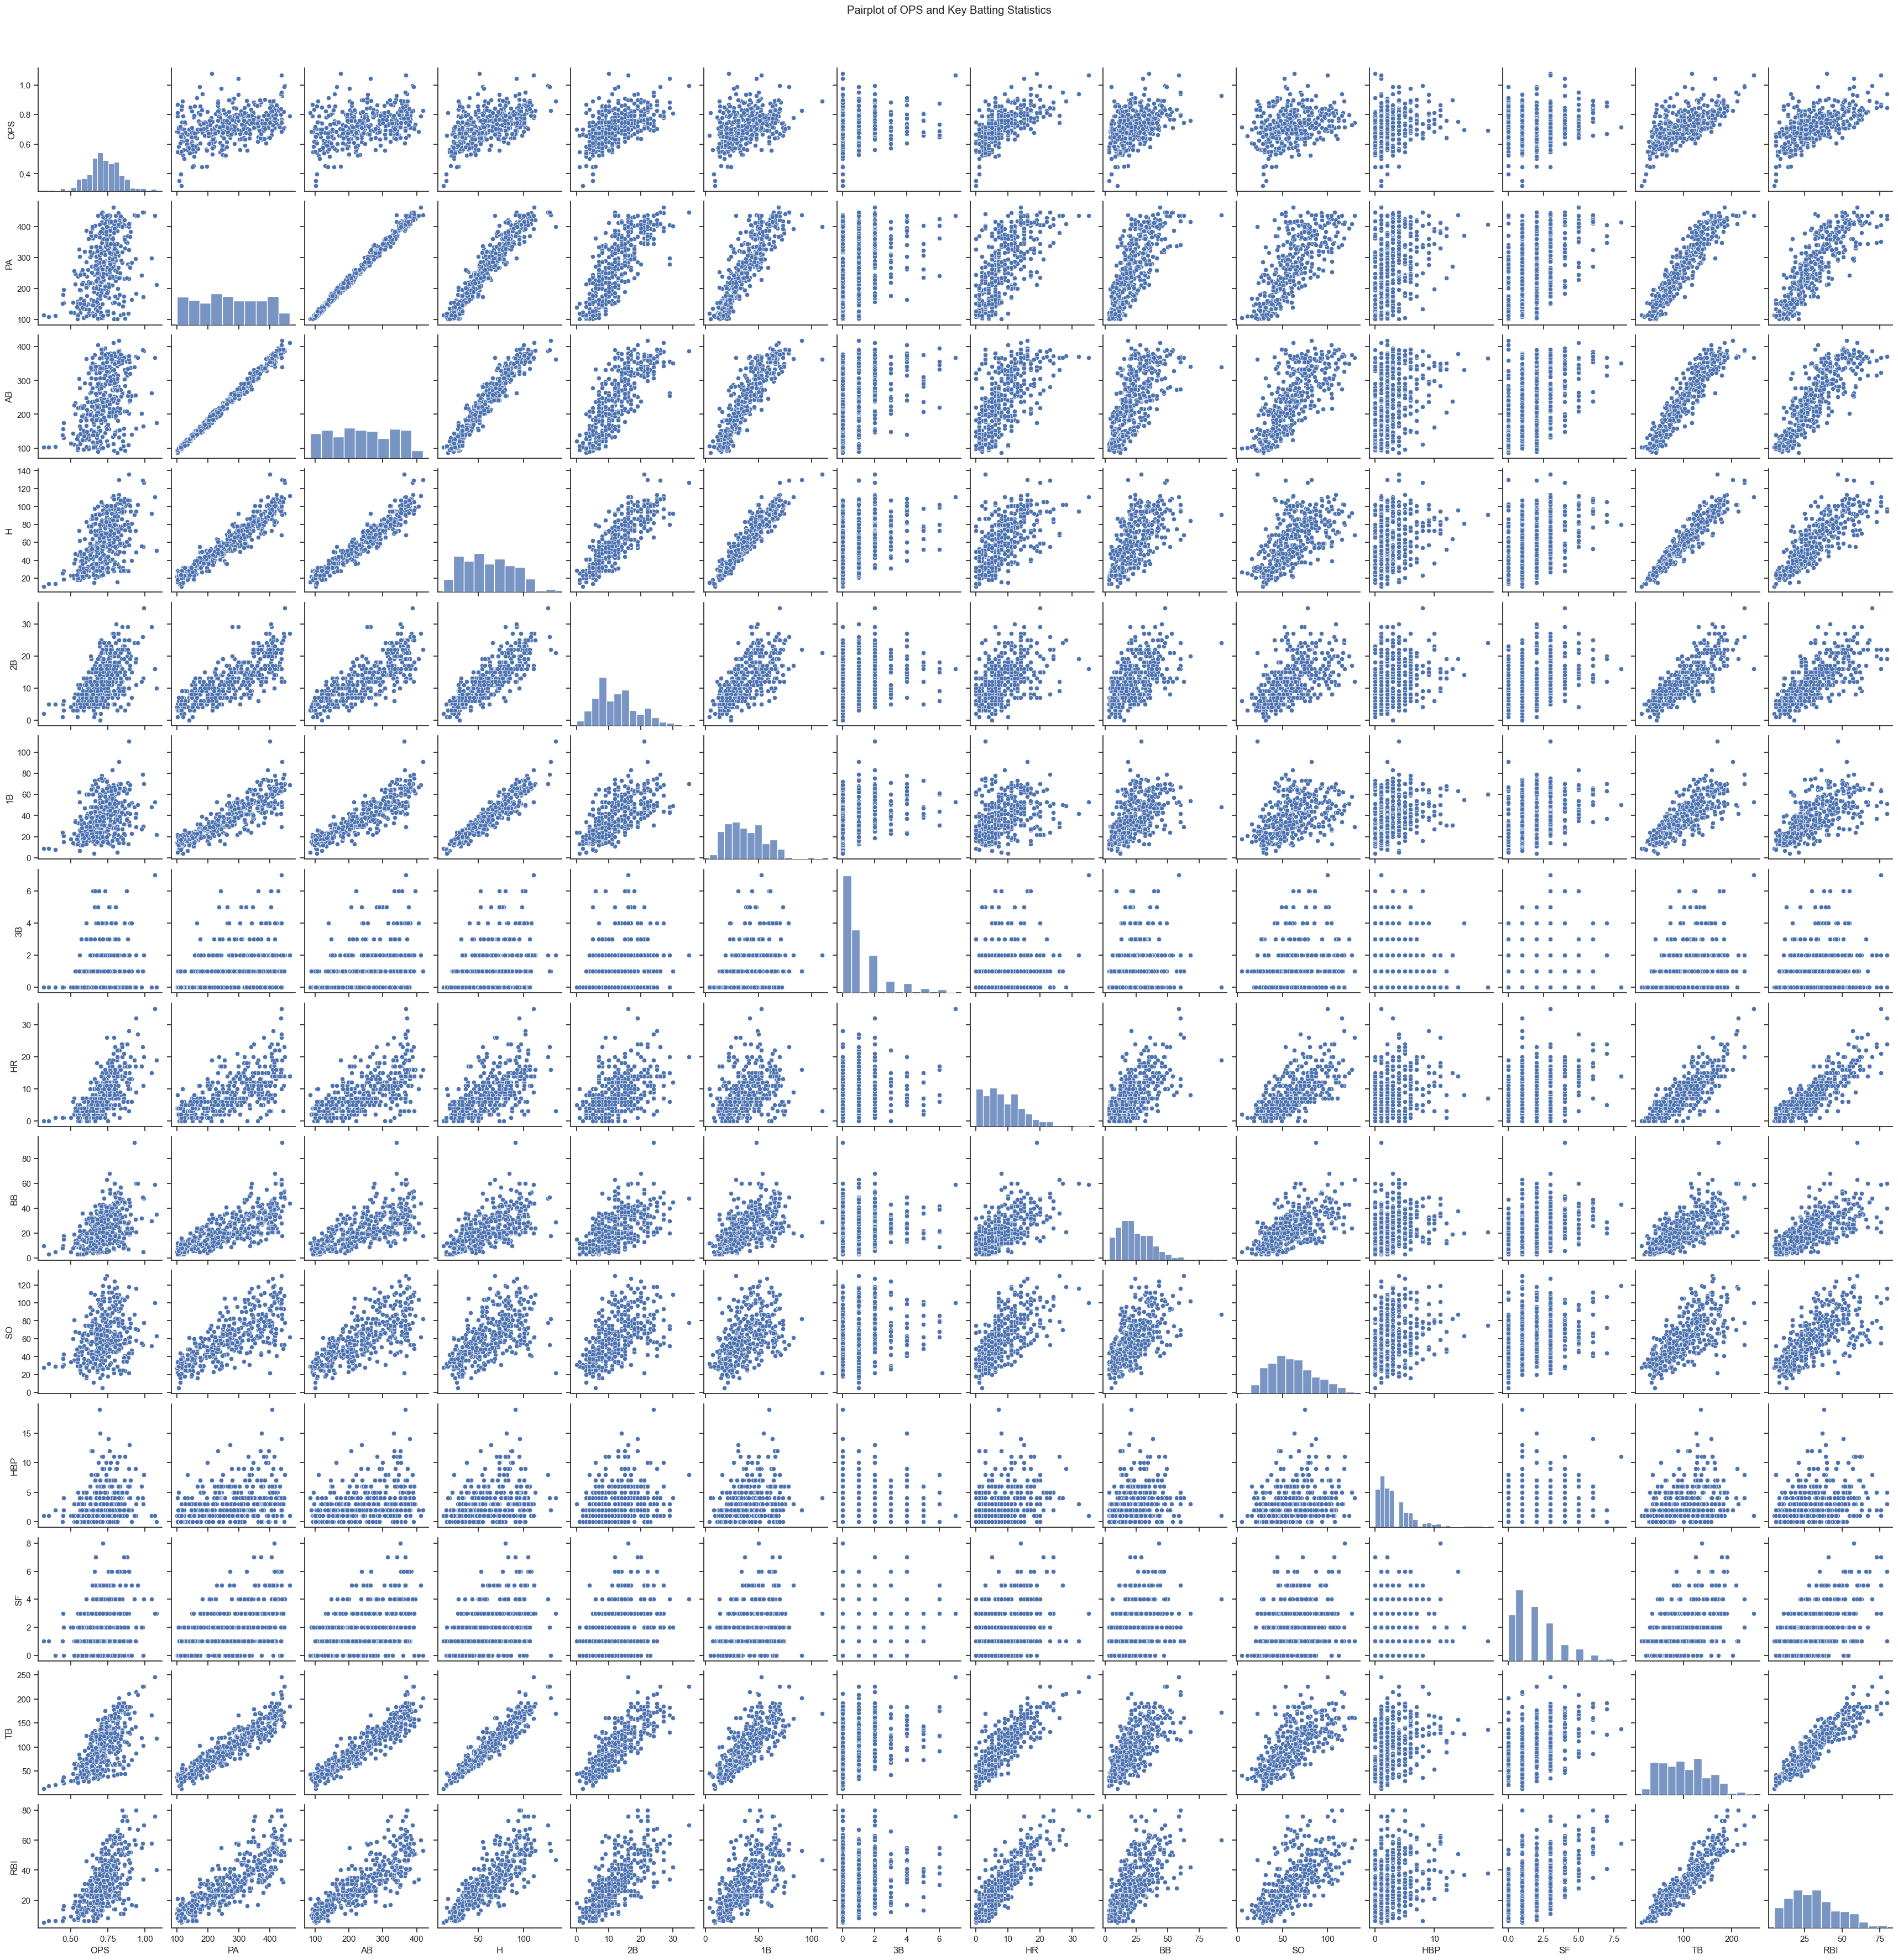

In [191]:
# Define relevant columns for OPS analysis
pairplot_cols = [
    'OPS', 'PA', 'AB', 'H', '2B', '3B', 'HR',
    'BB', 'SO', 'HBP', 'SF', 'TB', 'RBI'
]

# Calculate singles (1B)
dfMLB['1B'] = pd.to_numeric(dfMLB['H'], errors='coerce') - (
    pd.to_numeric(dfMLB['2B'], errors='coerce') +
    pd.to_numeric(dfMLB['3B'], errors='coerce') +
    pd.to_numeric(dfMLB['HR'], errors='coerce')
)

# Add '1B' to analysis columns
pairplot_cols.insert(5, '1B')  # insert after 'H'

# Convert all columns to numeric
for col in pairplot_cols:
    dfMLB[col] = pd.to_numeric(dfMLB[col], errors='coerce')

# Drop rows with any missing values
df_pair = dfMLB[pairplot_cols].dropna()

# Generate the pairplot
sns.set(style="ticks")
sns.pairplot(df_pair, height=2.5)
plt.suptitle("Pairplot of OPS and Key Batting Statistics", y=1.02)
plt.show()

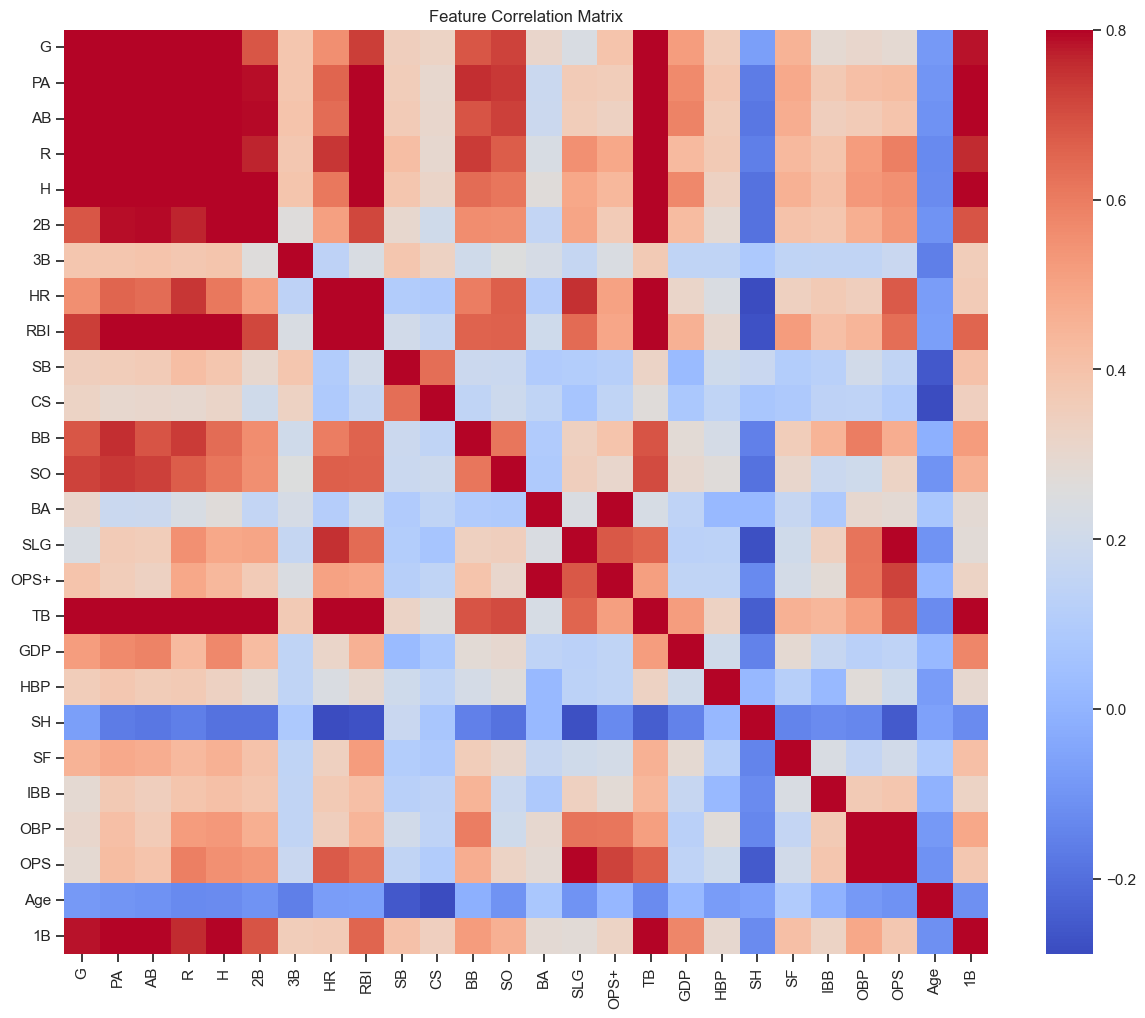

In [192]:
# Compute correlation matrix
dfMLB = dfMLB.select_dtypes(include=[np.number])
correlation_matrix = dfMLB.corr()

# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [193]:
# 2. Compute rates for double, triples, homeruns, and avg
dfMLB['DoubleRate'] = dfMLB['2B']      / dfMLB['AB']
dfMLB['TripleRate'] = dfMLB['3B']      / dfMLB['AB']
dfMLB['HomerunRate'] = dfMLB['HR']     / dfMLB['AB']
dfMLB['Avg']        = dfMLB['H']       / dfMLB['AB']

# Inspect
dfMLB[['DoubleRate','TripleRate','HomerunRate','Avg']].head()

DoubleRate  TripleRate  HomerunRate       Avg
1    0.031496    0.000000     0.039370  0.173228
2    0.030769    0.005128     0.035897  0.235897
3    0.057143    0.000000     0.108571  0.291429
5    0.083333    0.007576     0.053030  0.250000
6    0.042254    0.003521     0.042254  0.235915

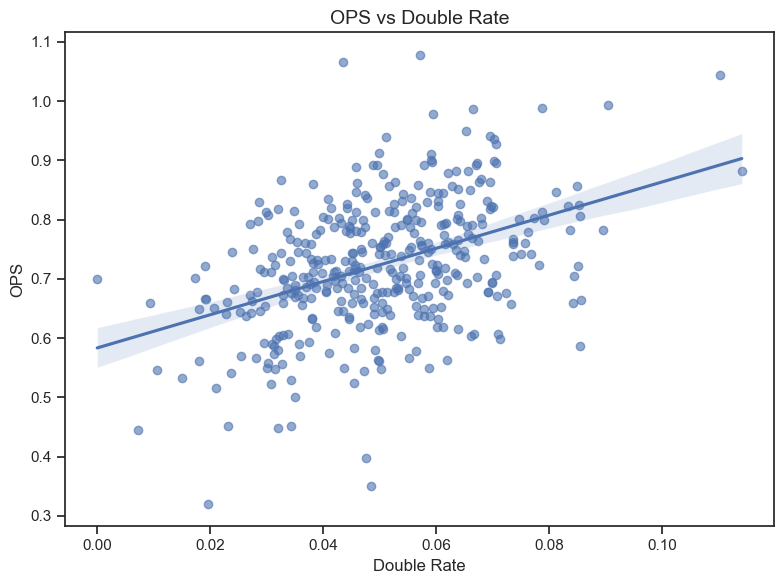

In [194]:
#Regression Plot – Double Rate vs OPS 

plt.figure(figsize=(8,6))
sns.regplot(
    data=dfMLB,
    x='DoubleRate',
    y='OPS',
    scatter_kws={'alpha':0.6}
)
plt.title('OPS vs Double Rate', fontsize=14)
plt.xlabel('Double Rate')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

## Section 3: Data Analytics <a class="anchor" id="data-analytics"></a>

In [195]:
# Define features and target
X = dfMLB.drop(columns=['Player', 'OPS'])
y = dfMLB['OPS']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

KeyError: "['Player'] not found in axis"

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train,
                             cv=5, scoring='r2')
    print(f"{name}: Mean R2 = {scores.mean():.3f}  (std = {scores.std():.3f})")

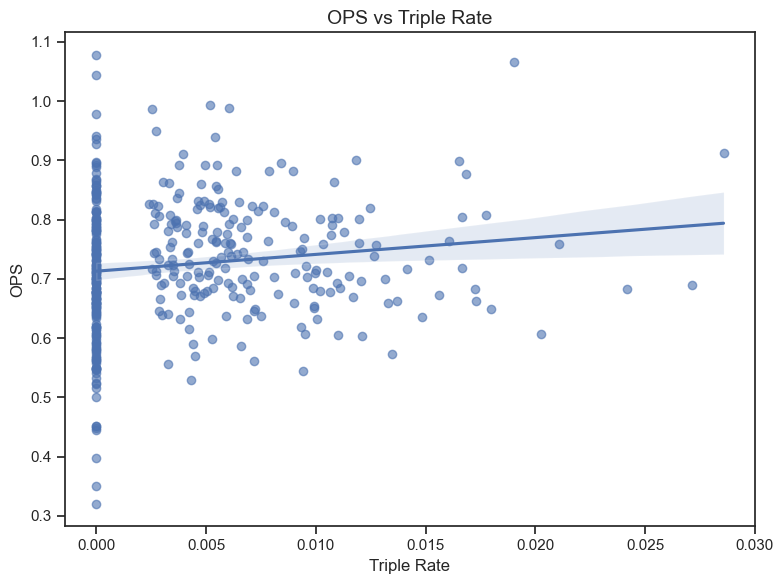

In [ ]:
# ── Cell 4: Regression Plot – Triple Rate vs OPS ──
plt.figure(figsize=(8,6))
sns.regplot(
    data=dfMLB,
    x='TripleRate',
    y='OPS',
    scatter_kws={'alpha':0.6}
)
plt.title('OPS vs Triple Rate', fontsize=14)
plt.xlabel('Triple Rate')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

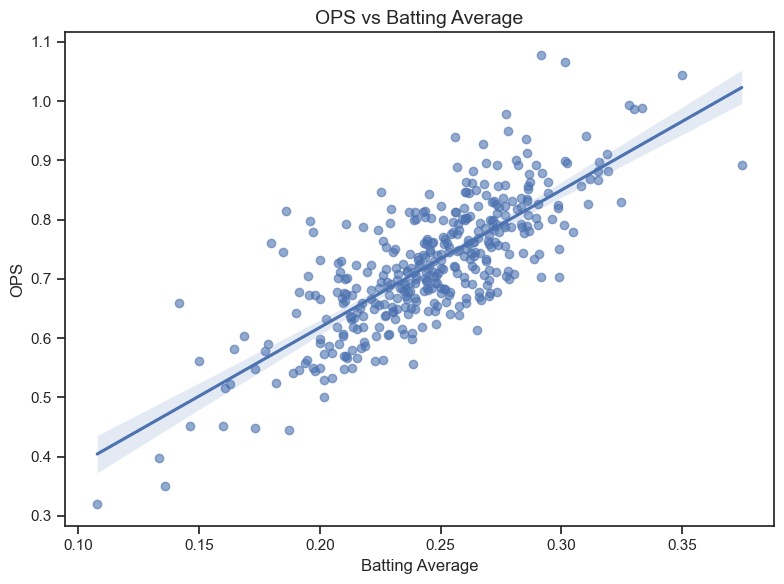

In [ ]:
# ── Cell 5: Regression Plot – Batting Average vs OPS ──
plt.figure(figsize=(8,6))
sns.regplot(
    data=dfMLB,
    x='Avg',
    y='OPS',
    scatter_kws={'alpha':0.6}
)
plt.title('OPS vs Batting Average', fontsize=14)
plt.xlabel('Batting Average')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

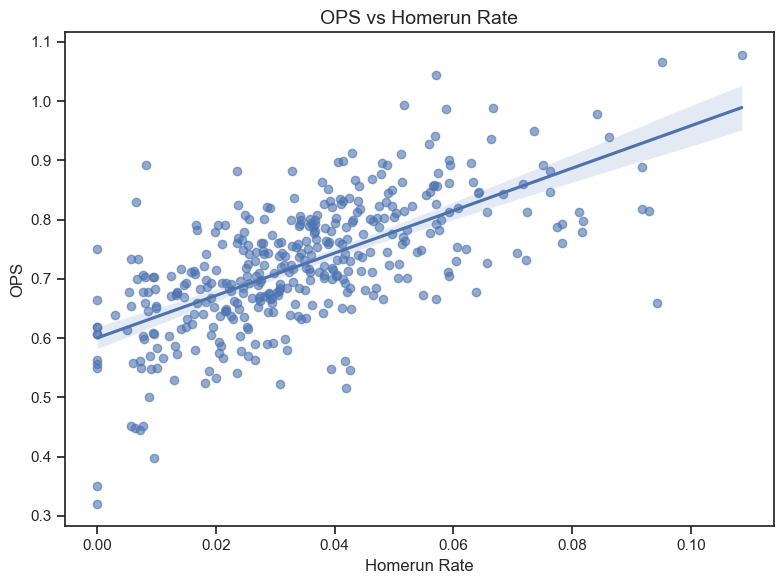

In [ ]:
# ── Cell 5: Regression Plot – Batting Average vs OPS ──
plt.figure(figsize=(8,6))
sns.regplot(
    data=dfMLB,
    x='HomerunRate',
    y='OPS',
    scatter_kws={'alpha':0.6}
)
plt.title('OPS vs Homerun Rate', fontsize=14)
plt.xlabel('Homerun Rate')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

In [ ]:
# Additional Metrics Calculated to get more Visualization and Correlation

# 1. Walk Rate, Strikeout Rate, SB Rate
dfMLB['WalkRate']      = dfMLB['BB'] / dfMLB['PA']
dfMLB['StrikeoutRate'] = dfMLB['SO'] / dfMLB['PA']
dfMLB['SBR']           = dfMLB['SB'] / dfMLB['PA']

# 2. K/BB Ratio (guard against zero BB)
dfMLB['K_BB_Ratio']    = dfMLB['SO'] / dfMLB['BB'].replace(0, pd.NA)

# 3. Isolated Power (ISO)
dfMLB['ISO']           = dfMLB['SLG'] - dfMLB['Avg']

# 4. BABIP
dfMLB['BABIP'] = (
    dfMLB['H'] - dfMLB['HR']
) / (
    dfMLB['AB'] - dfMLB['SO'] - dfMLB['HR'] + dfMLB['SF']
)

# Quick check
dfMLB[['WalkRate','StrikeoutRate','SBR','K_BB_Ratio','ISO','BABIP']].head()

WalkRate  StrikeoutRate       SBR  K_BB_Ratio       ISO     BABIP
1  0.065217       0.217391  0.000000    3.333333  0.149606  0.180851
2  0.121076       0.242152  0.013453    2.000000  0.148718  0.288889
3  0.164319       0.295775  0.014085    1.800000  0.382857  0.333333
5  0.067114       0.315436  0.020134    4.700000  0.257576  0.320988
6  0.075949       0.110759  0.022152    1.458333  0.176056  0.231092

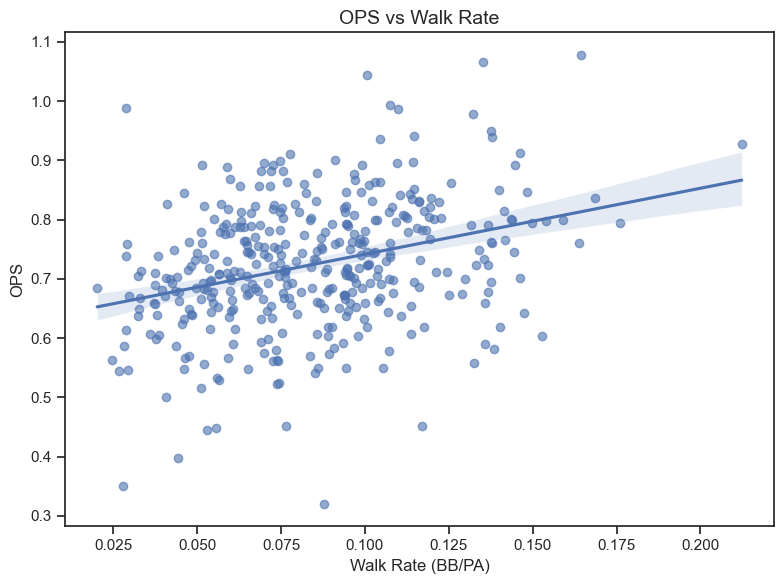

In [ ]:
# ── Cell 2: OPS vs Walk Rate ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='WalkRate', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs Walk Rate', fontsize=14)
plt.xlabel('Walk Rate (BB/PA)')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

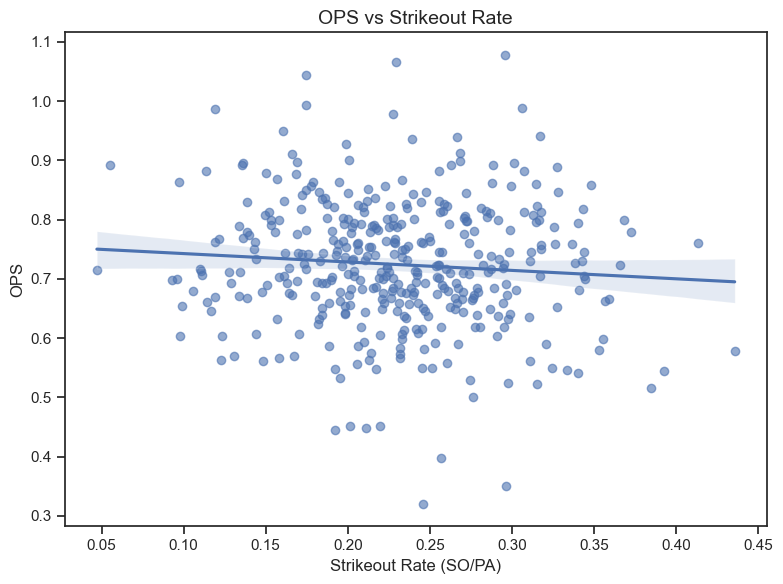

In [ ]:
# ── Cell 3: OPS vs Strikeout Rate ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='StrikeoutRate', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs Strikeout Rate', fontsize=14)
plt.xlabel('Strikeout Rate (SO/PA)')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

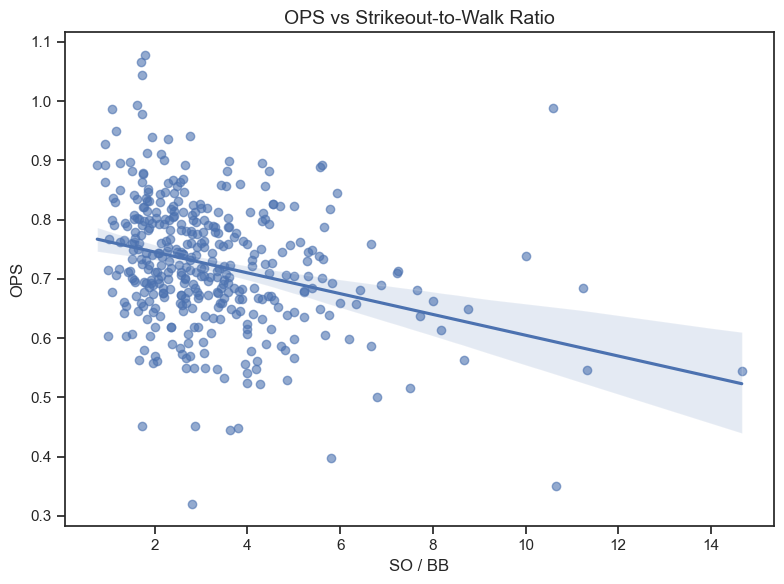

In [ ]:
# ── Cell 4: OPS vs K/BB Ratio ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='K_BB_Ratio', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs Strikeout-to-Walk Ratio', fontsize=14)
plt.xlabel('SO / BB')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

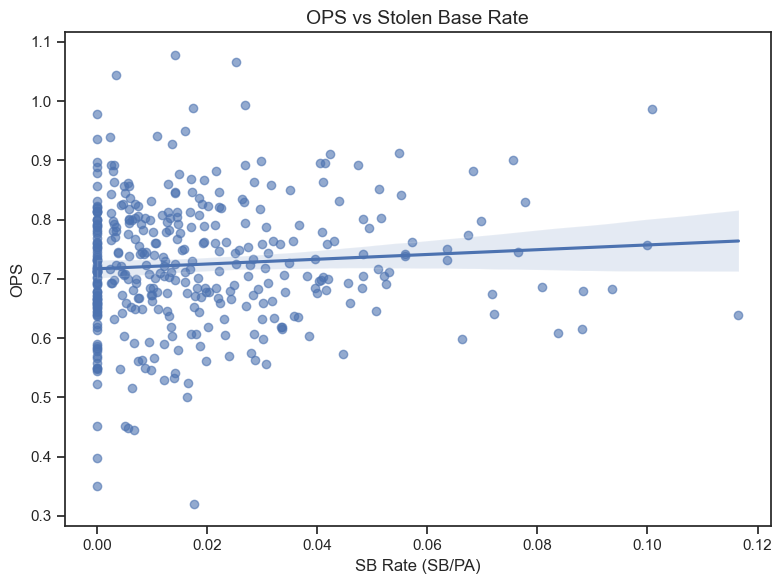

In [ ]:
# ── Cell 5: OPS vs Stolen Base Rate ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='SBR', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs Stolen Base Rate', fontsize=14)
plt.xlabel('SB Rate (SB/PA)')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

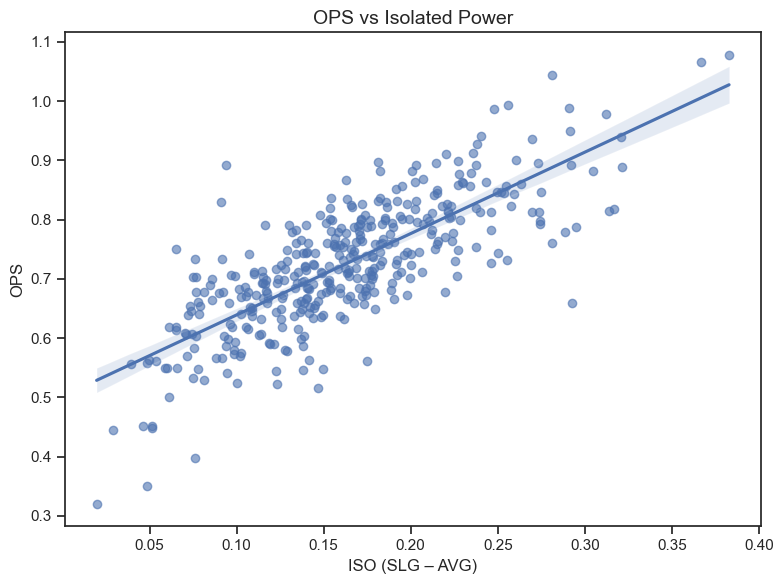

In [ ]:
# ── Cell 6: OPS vs Isolated Power (ISO) ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='ISO', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs Isolated Power', fontsize=14)
plt.xlabel('ISO (SLG – AVG)')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

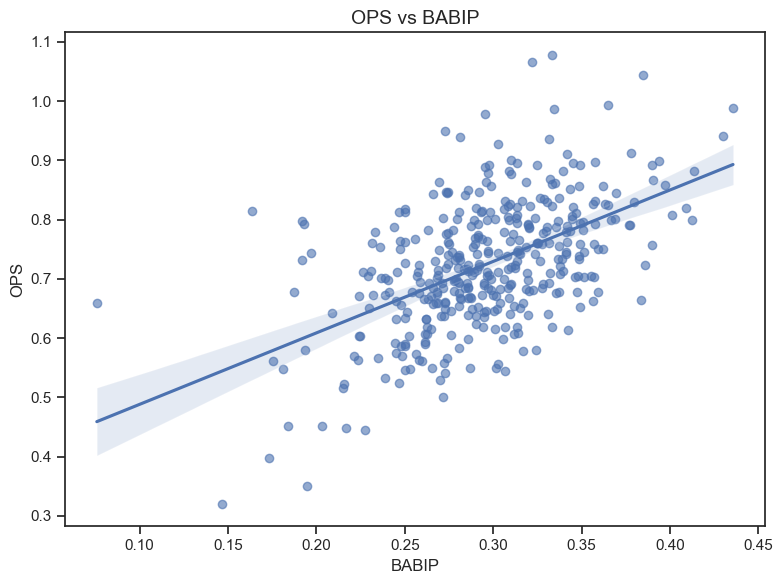

In [ ]:
# ── Cell 7: OPS vs BABIP ──
plt.figure(figsize=(8,6))
sns.regplot(data=dfMLB, x='BABIP', y='OPS', scatter_kws={'alpha':0.6})
plt.title('OPS vs BABIP', fontsize=14)
plt.xlabel('BABIP')
plt.ylabel('OPS')
plt.tight_layout()
plt.show()

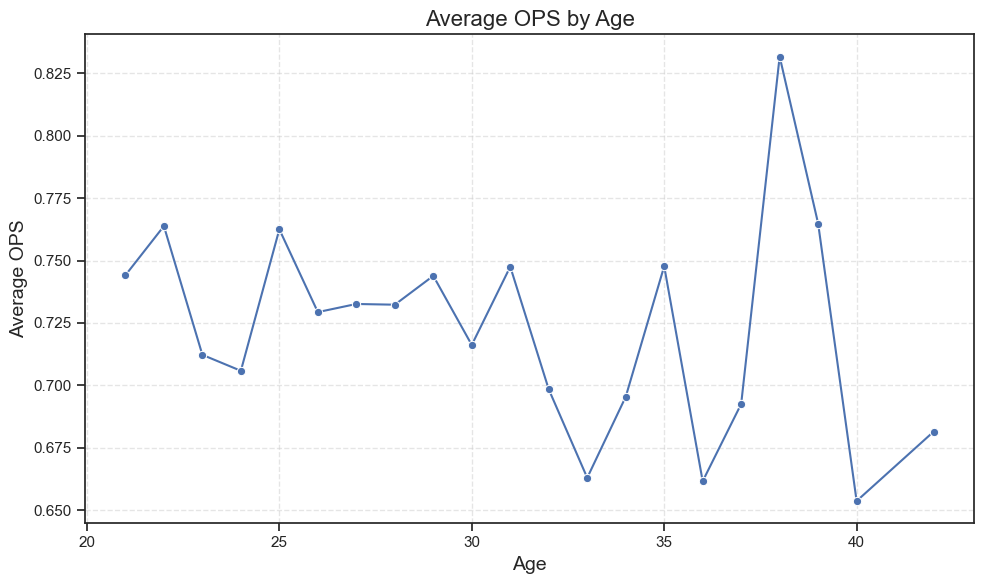

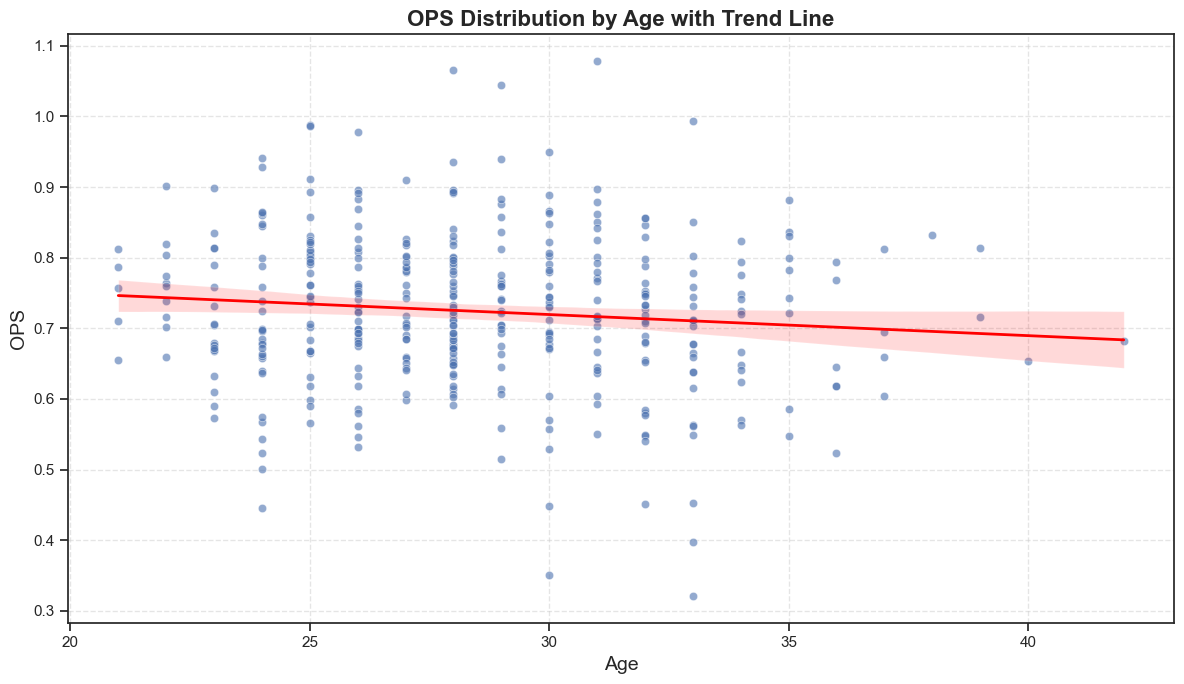

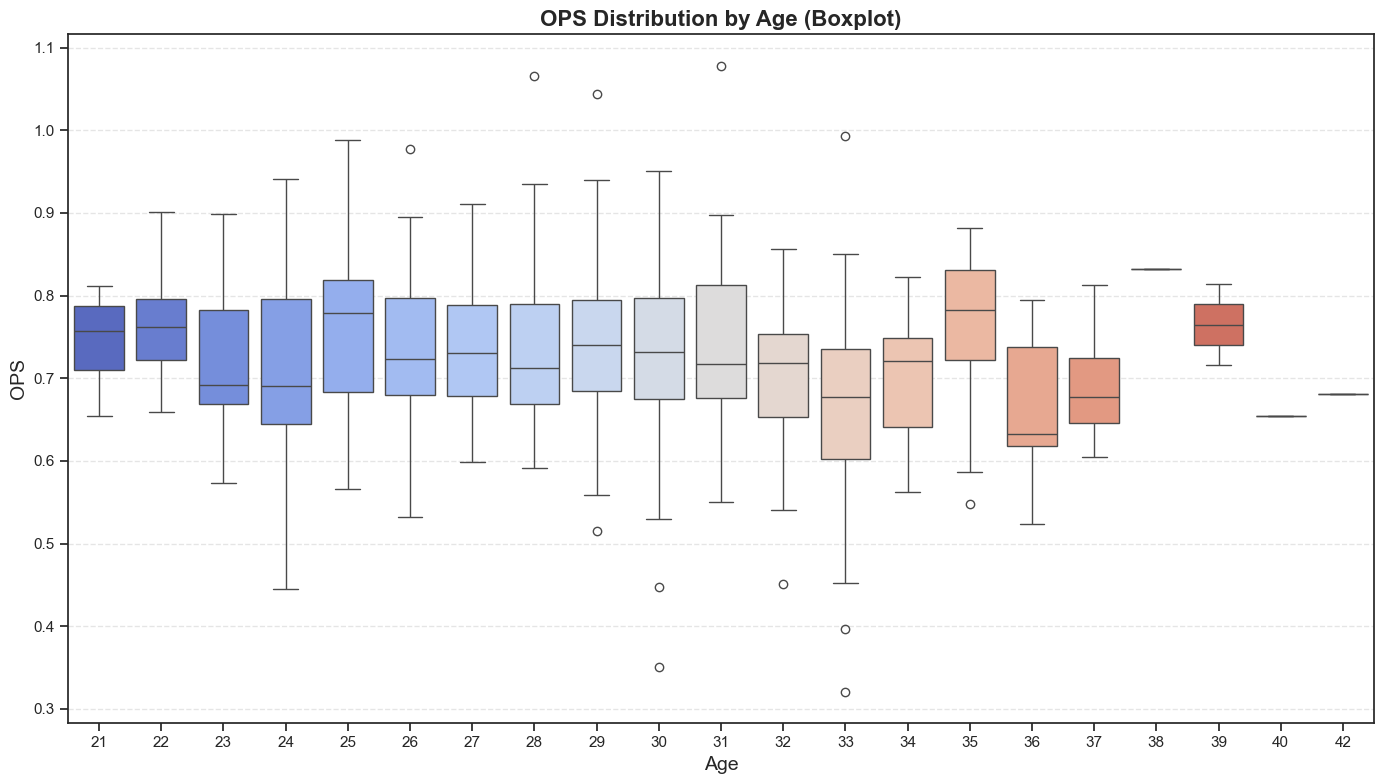

In [ ]:
# Compute average OPS by Age and plot it
age_ops = dfMLB.groupby('Age', as_index=False)['OPS'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=age_ops, x='Age', y='OPS', marker='o')
plt.title('Average OPS by Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Average OPS', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 7))
sns.scatterplot(data=dfMLB, x='Age', y='OPS', alpha=0.6)
sns.regplot(data=dfMLB, x='Age', y='OPS', scatter=False, color='red', line_kws={'linewidth':2})

plt.title('OPS Distribution by Age with Trend Line', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('OPS', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 8))
sns.boxplot(data=dfMLB, x='Age', y='OPS', palette='coolwarm')

plt.title('OPS Distribution by Age (Boxplot)', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('OPS', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


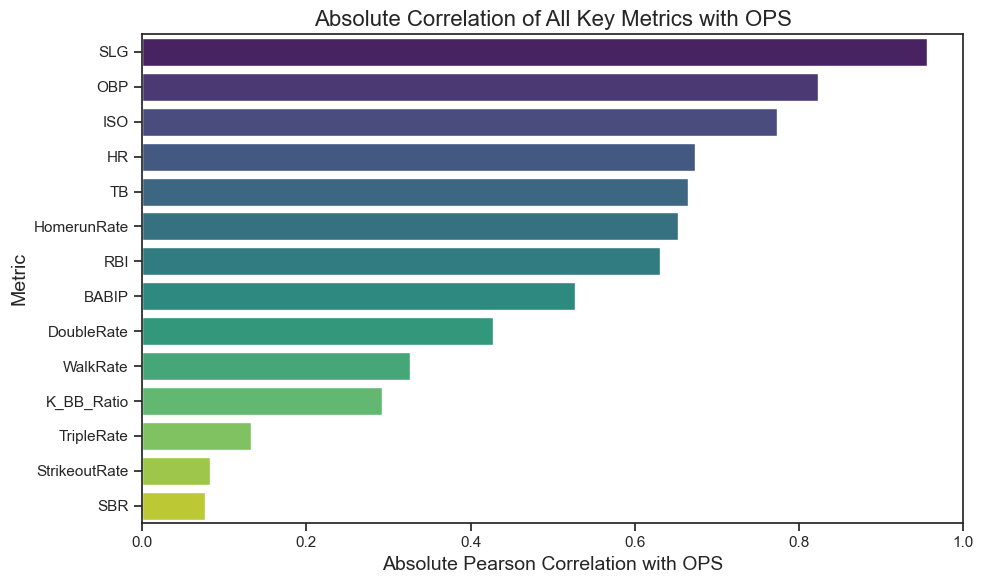

In [ ]:
# 1. All derived metrics
metrics = [
    'OBP','SLG','TB','RBI','HR',
    'HomerunRate','DoubleRate','TripleRate',
    'WalkRate','StrikeoutRate','SBR','K_BB_Ratio',
    'ISO','BABIP'
]

# 2. Ensure numeric and drop any rows with NaN in these columns + OPS
df_corr = dfMLB[metrics + ['OPS']].dropna()

# 3. Compute the absolute correlations with OPS
abs_corr = df_corr.corr()['OPS'].abs().drop('OPS').sort_values(ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=abs_corr.values, y=abs_corr.index, palette='viridis')
plt.title('Absolute Correlation of All Key Metrics with OPS', fontsize=16)
plt.xlabel('Absolute Pearson Correlation with OPS', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

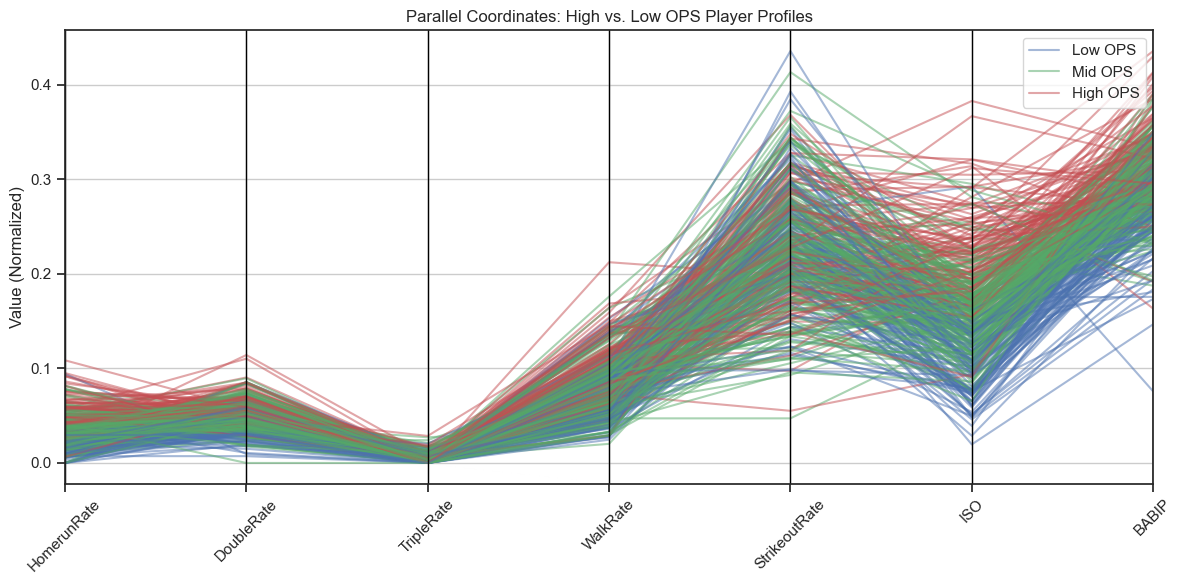

In [ ]:
from pandas.plotting import parallel_coordinates

# Tag each player as High or Low OPS
q1 = dfMLB['OPS'].quantile(0.75)
q3 = dfMLB['OPS'].quantile(0.25)
dfMLB['OPS_Group'] = dfMLB['OPS'].apply(lambda x: 'High OPS' if x >= q1 else ('Low OPS' if x <= q3 else 'Mid OPS'))

# Select a handful of normalized metrics
cols = ['HomerunRate','DoubleRate','TripleRate','WalkRate','StrikeoutRate','ISO','BABIP','OPS_Group']
df_pc = dfMLB[cols].dropna()

plt.figure(figsize=(12,6))
parallel_coordinates(df_pc, 'OPS_Group', color=['#4C72B0','#55A868','#C44E52'], alpha=0.5)
plt.title('Parallel Coordinates: High vs. Low OPS Player Profiles')
plt.ylabel('Value (Normalized)')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Data Analysis


Models: Since our data is numerical we predict that a supervised training model like xgboost will perform the best. This is due to the fact that we are trying to predict a numerical value (OPS) using independent variables like Age, G, PA, ... This makes supervised learning the superior choice. However, there is also a change that a unsupervised model like k-means clustering will perform better on the training model, given their superier ablity to discover patterns. Is there are outlier varibles like age that have a pattern to them to cause the perdiction then this could prove superior. This is unlikely. The usage of both of these on our data will allow us to see if unsupervised or supervised performs better. If unsupervised performs better it is likely to due with the heavy effect of a weird pattern going on with the data such as spikes in ages that have a heavy effect on the OPS.

Variables: 
Dependent: 'OPS'

Independent: 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'HBP', 'SF', 'TB', 'GDP', 'HomerunRate', 'DoubleRate', 'TripleRate', 'WalkRate', 'StrikeoutRate', 'SBR', 'K_BB_Ratio', 'BABIP'

Variables to remove: 'OBP' and 'SLG' these will all be remoeved as 'OPS' is the variable we are trying to predict and it is made up of 'OBP' + 'SLG' so to include these would cause dataleakage. 

Evaluation: We will be using R^2, Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) to evaluate the models. R^2 measures the proportion of variance in the dependent variable (OPS) as explained by the independent variables. 0-1 the closer it is to 1 the better it captures the underlying patterns in the data. RMSE tells us th e models sensetivity to ourliers, since we are including factors like age that do not necessarily seem to align with predicting OPS it is important to insure that predictions are within our acceptable range. MAE is less sensitive to outliers than RMSE and will provide a fuller understanding of the average perdictive accuracy of our model.


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

1. Use the cleaned dataset
2. Select features that don't cause data leakage. This means we need to exclude OPS, OBP, SLG as they are components of what we're trying to predict. Since OPs is pulled from OBP and SLG.
3. Create feature matrix X and target variable y

In [ ]:
df = dfMLB 

features = [
    'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 
    'SB', 'CS', 'BB', 'SO', 'HBP', 'SF', 'TB', 'GDP',
    'HomerunRate', 'DoubleRate', 'TripleRate', 'WalkRate', 
    'StrikeoutRate', 'SBR', 'K_BB_Ratio', 'BABIP'
]

X = df[features]
y = df['OPS']

1. Handle any remaining missing values
2. Split the data
3. Create DMatrix for XGBoost
4. Parameters for XGBoost
5. Train model with evaluation set

In [ ]:
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42,
    'early_stopping_rounds': 10
}

eval_list = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100,
    evals=eval_list,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-rmse:0.09817	eval-rmse:0.10895
[1]	train-rmse:0.09122	eval-rmse:0.10287
[2]	train-rmse:0.08460	eval-rmse:0.09706
[3]	train-rmse:0.07879	eval-rmse:0.09185
[4]	train-rmse:0.07372	eval-rmse:0.08745
[5]	train-rmse:0.06878	eval-rmse:0.08283
[6]	train-rmse:0.06412	eval-rmse:0.07846
[7]	train-rmse:0.06008	eval-rmse:0.07575
[8]	train-rmse:0.05624	eval-rmse:0.07259
[9]	train-rmse:0.05283	eval-rmse:0.06988
[10]	train-rmse:0.04974	eval-rmse:0.06808
[11]	train-rmse:0.04658	eval-rmse:0.06572
[12]	train-rmse:0.04397	eval-rmse:0.06396
[13]	train-rmse:0.04135	eval-rmse:0.06205
[14]	train-rmse:0.03921	eval-rmse:0.06090
[15]	train-rmse:0.03695	eval-rmse:0.05940
[16]	train-rmse:0.03482	eval-rmse:0.05779
[17]	train-rmse:0.03298	eval-rmse:0.05628
[18]	train-rmse:0.03112	eval-rmse:0.05466
[19]	train-rmse:0.02950	eval-rmse:0.05379
[20]	train-rmse:0.02794	eval-rmse:0.05250
[21]	train-rmse:0.02657	eval-rmse:0.05134
[22]	train-rmse:0.02533	eval-rmse:0.05025
[23]	train-rmse:0.02408	eval-rmse:0.04955
[2

Above you can see the modles improving with each iteration we limit it so as not to overfit the model.
1. Make predictions
2. Calculate metrics to see the accuracy of our model
3. display the data to us

In [ ]:
y_pred = model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Model Performance Metrics:
R-squared (R2) Score: 0.8975
Root Mean Squared Error (RMSE): 0.0371
Mean Absolute Error (MAE): 0.0269


Above we can see that our model performs extremely well: the R^2 tells us that the target variable is tracked about 89.75% of the time by our model, RMSE of 0.0371the average magnitude of error is 3.71% extremely low and the MAE of 0.0269 means we are off by an average unit of 0.0268.

1. Show the important independent variables in predicting OPS

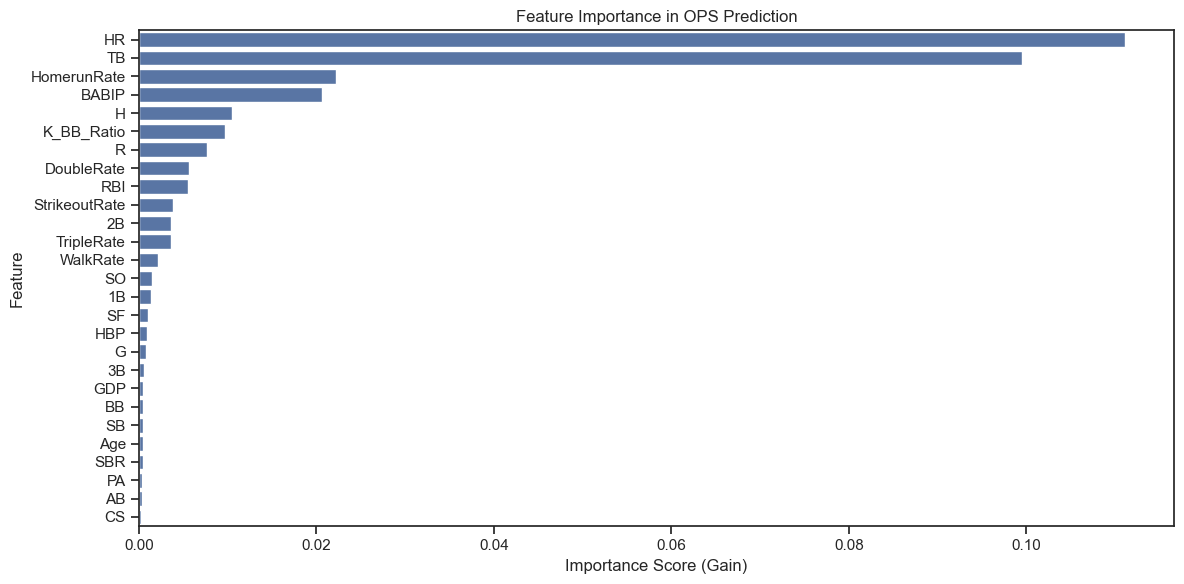

In [ ]:
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance': list(importance_scores.values())
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in OPS Prediction')
plt.xlabel('Importance Score (Gain)')
plt.tight_layout()
plt.show()

1. Easy data visualization by creating a scatter plot of Predicted vs Actual OPS

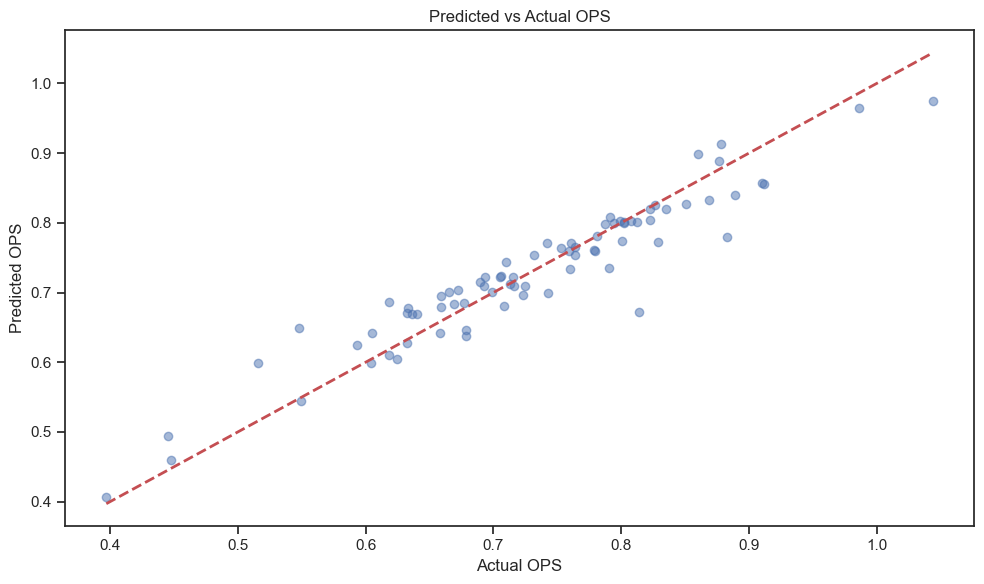

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual OPS')
plt.ylabel('Predicted OPS')
plt.title('Predicted vs Actual OPS')
plt.tight_layout()
plt.show()

1. Calculate prediction errors
2. Plot error distribution
3. Print error statistics

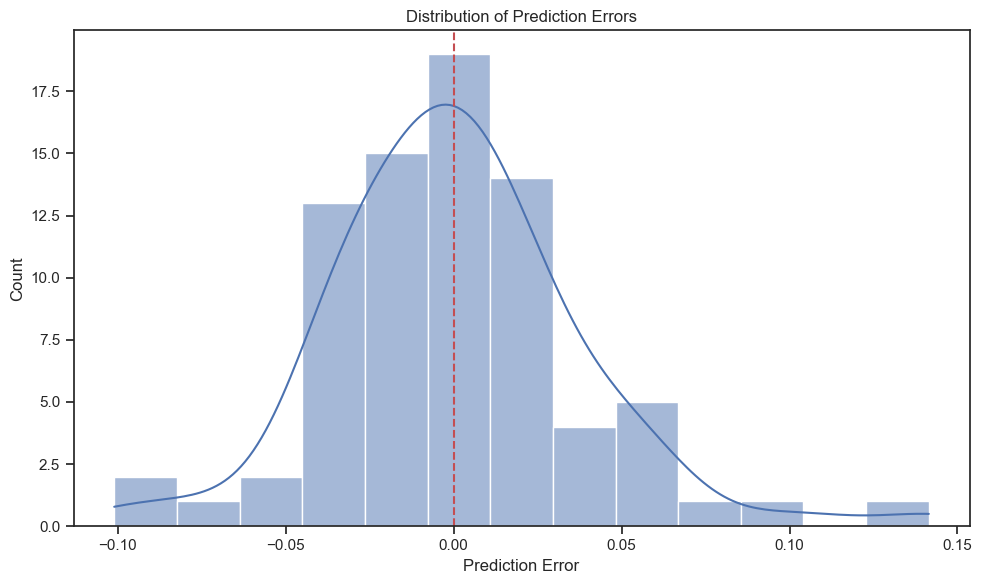


Error Statistics:
Mean Error: 0.0007
Standard Deviation of Error: 0.0373
Median Error: -0.0000


In [ ]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.4f}")
print(f"Standard Deviation of Error: {errors.std():.4f}")
print(f"Median Error: {np.median(errors):.4f}")

## This is the Random Forest Model Analysis

1. Train a Random Forest 
2. Initialize and train Random Forest model
3. Make predictions
4. Calculate metrics

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("\nRandom Forest Model Performance Metrics:")
print(f"R-squared (R2) Score: {rf_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")


Random Forest Model Performance Metrics:
R-squared (R2) Score: 0.7987
Root Mean Squared Error (RMSE): 0.0519
Mean Absolute Error (MAE): 0.0394


1. Plot Random Forest Feature Importance

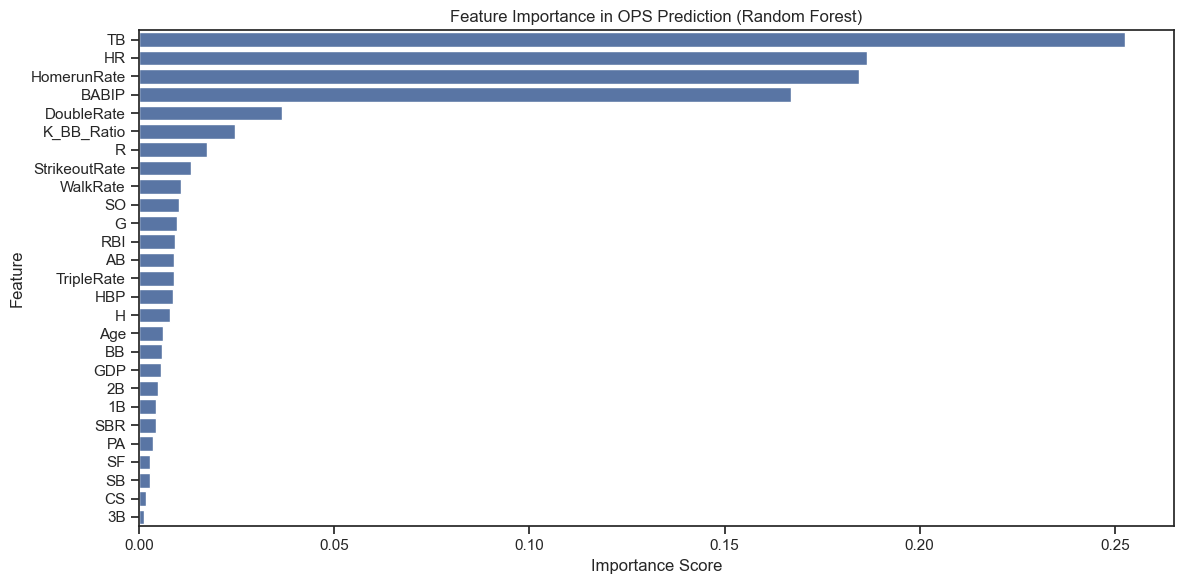

In [ ]:
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=rf_importance, x='Importance', y='Feature')
plt.title('Feature Importance in OPS Prediction (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Compare actual vs predicted values

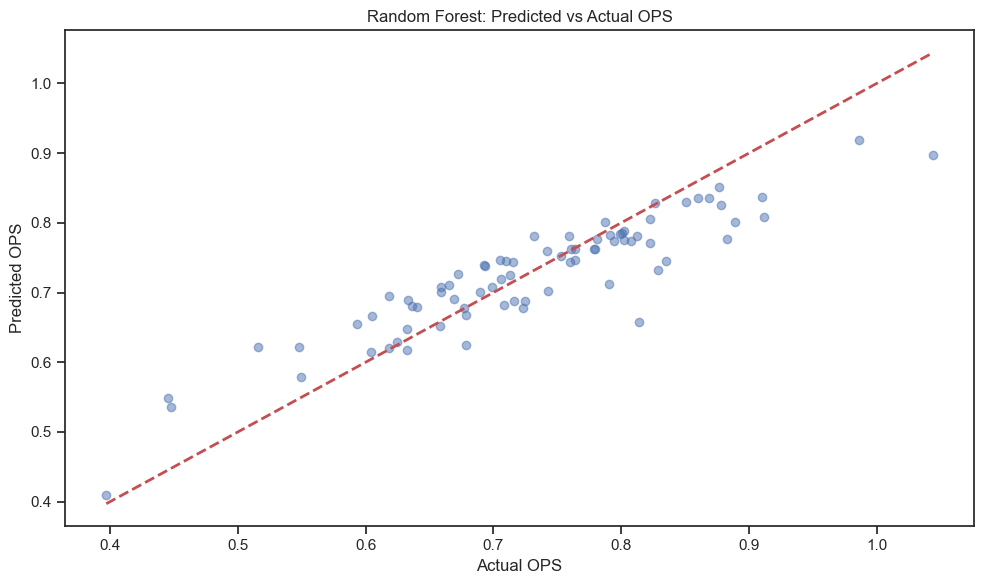

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual OPS')
plt.ylabel('Predicted OPS')
plt.title('Random Forest: Predicted vs Actual OPS')
plt.tight_layout()
plt.show()

Calculate and plot Random Forest prediction errors

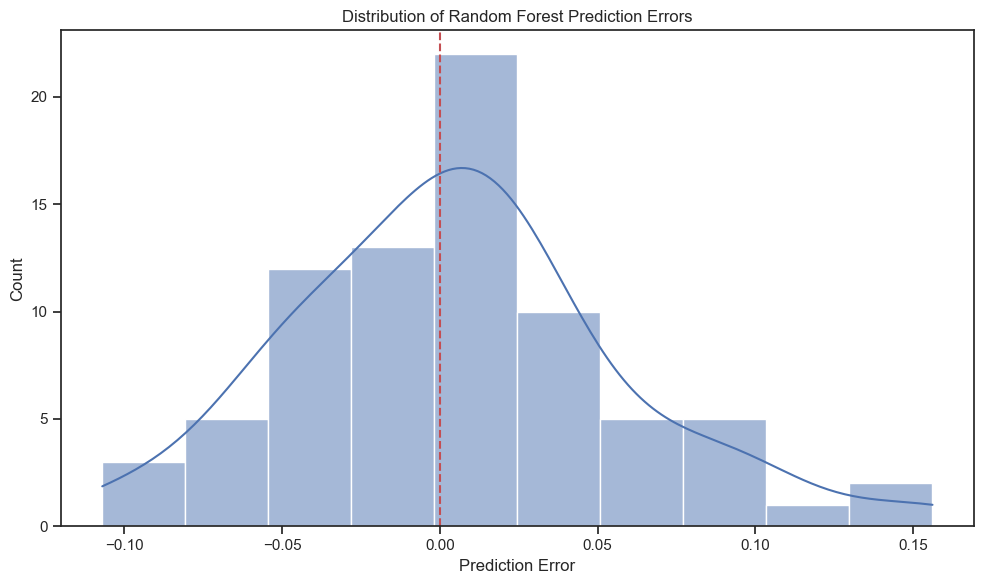


Random Forest Error Statistics:
Mean Error: 0.0049
Standard Deviation of Error: 0.0520
Median Error: 0.0029


In [ ]:
rf_errors = y_test - rf_pred

plt.figure(figsize=(10, 6))
sns.histplot(rf_errors, kde=True)
plt.title('Distribution of Random Forest Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

print("\nRandom Forest Error Statistics:")
print(f"Mean Error: {rf_errors.mean():.4f}")
print(f"Standard Deviation of Error: {rf_errors.std():.4f}")
print(f"Median Error: {np.median(rf_errors):.4f}")

## This is the K-mean clustering model
1. Prepare Features for Clustering
2. Prepare the data
3. Scale the features

In [ ]:
cluster_features = [
    'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 
    'SB', 'CS', 'BB', 'SO', 'HBP', 'SF', 'TB', 'GDP',
    'HomerunRate', 'DoubleRate', 'TripleRate', 'WalkRate', 
    'StrikeoutRate', 'SBR', 'K_BB_Ratio', 'BABIP'
]

X = dfMLB[cluster_features]
y = dfMLB['OPS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

1. Determine Optimal Number of Clusters
2. Elbow Method with explicit n_jobs parameter
3. Plot elbow curve
4. Print inertia values for better decision making
5. Calculate elbow point using the percentage change

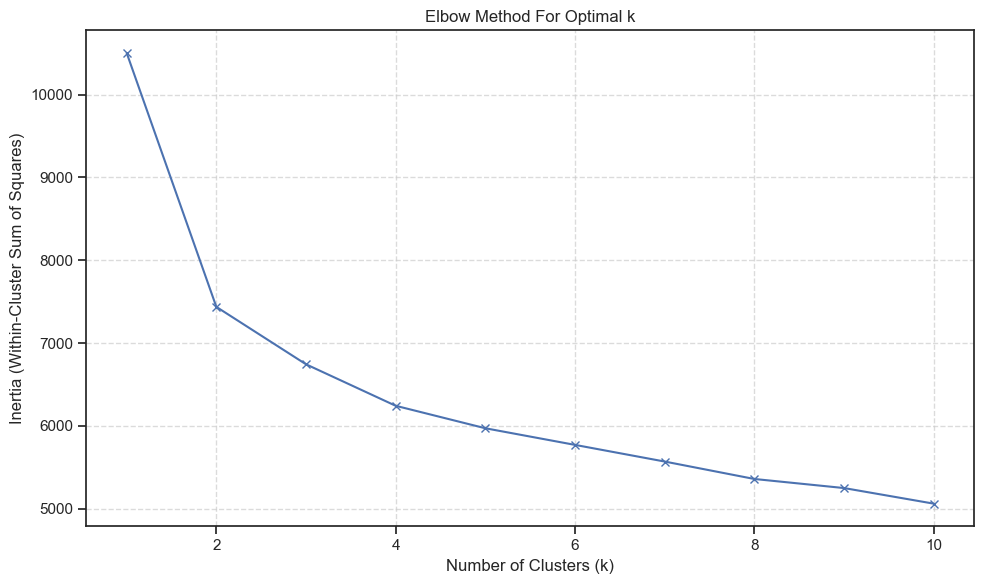


Inertia values for each k:
k=1: 10503.00
k=2: 7437.39
k=3: 6744.12
k=4: 6243.17
k=5: 5971.80
k=6: 5771.07
k=7: 5569.97
k=8: 5359.47
k=9: 5249.95
k=10: 5061.75

Suggested optimal k based on elbow method: 4


In [ ]:
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nInertia values for each k:")
for k, inertia in zip(K, inertias):
    print(f"k={k}: {inertia:.2f}")

inertia_changes = np.diff(inertias) / np.array(inertias)[:-1] * 100
optimal_k = np.argmin(np.abs(inertia_changes - np.mean(inertia_changes))) + 2
print(f"\nSuggested optimal k based on elbow method: {optimal_k}")


1. Choose optimal k from elbow plot (let's say k=4 for this example)
2. Add cluster labels to the dataframe
3. Initialize dictionary to store models
4. Train a decision tree for each cluster
    Get data for this cluster
    Split the data
    Train the model
    Store the model
    Make predictions and calculate scores

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

dfMLB['Cluster'] = cluster_labels

cluster_models = {}
cluster_scores = {}

for cluster in range(n_clusters):
    mask = cluster_labels == cluster
    X_cluster = X[mask]
    y_cluster = y[mask]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_cluster, y_cluster, test_size=0.2, random_state=42
    )
    
    model = DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    cluster_models[cluster] = model
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)  # ← Calculate MAE here
    
    cluster_scores[cluster] = {
        'size': sum(mask),
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    }

1. Analyze Cluster Characteristics
2. Print cluster statistics
3. Print top features for this cluster

In [ ]:
print("Cluster Statistics:")
for cluster in range(n_clusters):
    cluster_data = dfMLB[dfMLB['Cluster'] == cluster]
    print(f"\nCluster {cluster} (Size: {len(cluster_data)})")
    print(f"Average OPS: {cluster_data['OPS'].mean():.3f}")
    print(f"R2 Score: {cluster_scores[cluster]['r2']:.3f}")
    print(f"RMSE: {cluster_scores[cluster]['rmse']:.3f}")
    print(f"MAE: {cluster_scores[cluster]['mae']:.3f}")

    feature_importance = pd.DataFrame({
        'feature': cluster_features,
        'importance': cluster_models[cluster].feature_importances_
    })
    print("\nTop 5 Important Features:")
    print(feature_importance.nlargest(5, 'importance')[['feature', 'importance']])

Cluster Statistics:

Cluster 0 (Size: 194)
Average OPS: 0.769
R2 Score: 0.348
RMSE: 0.064
MAE: 0.049

Top 5 Important Features:
        feature  importance
19  HomerunRate    0.448993
17           TB    0.137392
20   DoubleRate    0.134936
26        BABIP    0.112795
1             G    0.051575

Cluster 1 (Size: 195)
Average OPS: 0.680
R2 Score: 0.533
RMSE: 0.060
MAE: 0.048

Top 5 Important Features:
          feature  importance
19    HomerunRate    0.520704
26          BABIP    0.346122
25     K_BB_Ratio    0.031540
20     DoubleRate    0.029609
23  StrikeoutRate    0.020448


The above cluster model performs worse than the gxboost model because our dataset is numerical which is better for a model like gxboost where as if the data was categorical a clustering model would perform best and likely it would be extremely hard if not impossible to apply a model like gxboost, we would need to do weird stuff with the data like one hot encoding.

1. create a visualisaiton of each cluster and their children

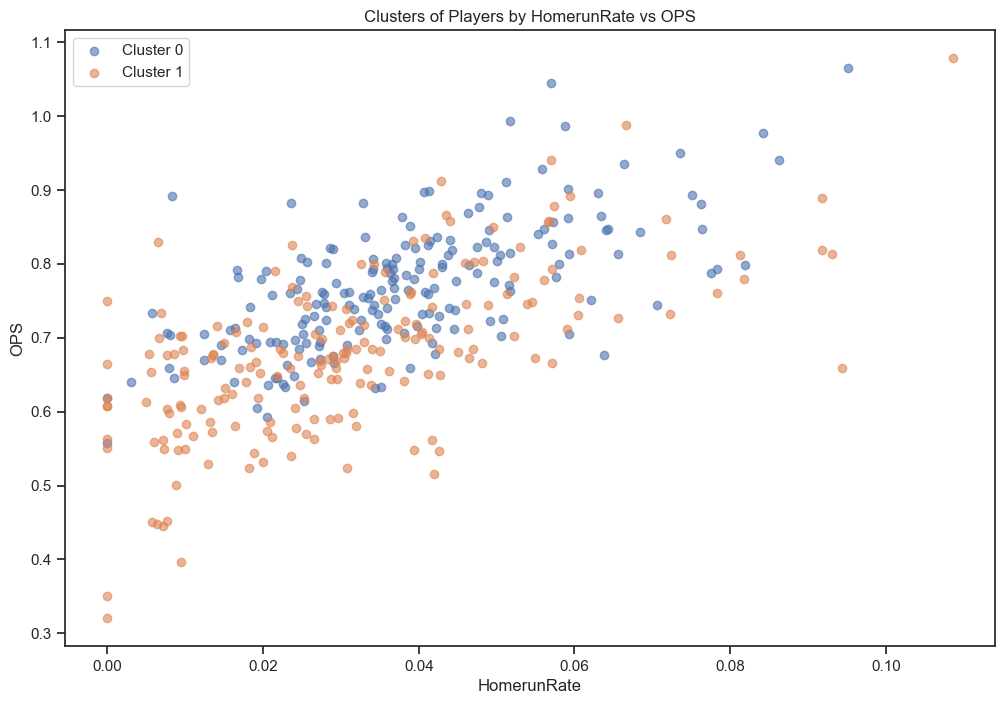

In [ ]:
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    mask = dfMLB['Cluster'] == cluster
    plt.scatter(
        dfMLB[mask]['HomerunRate'],
        dfMLB[mask]['OPS'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.xlabel('HomerunRate')
plt.ylabel('OPS')
plt.title('Clusters of Players by HomerunRate vs OPS')
plt.legend()
plt.show()

1. Analyze Feature Importance Across Clusters to see if they relate across models
2. Combine feature importance from all clusters
3. Plot heatmap of feature importance

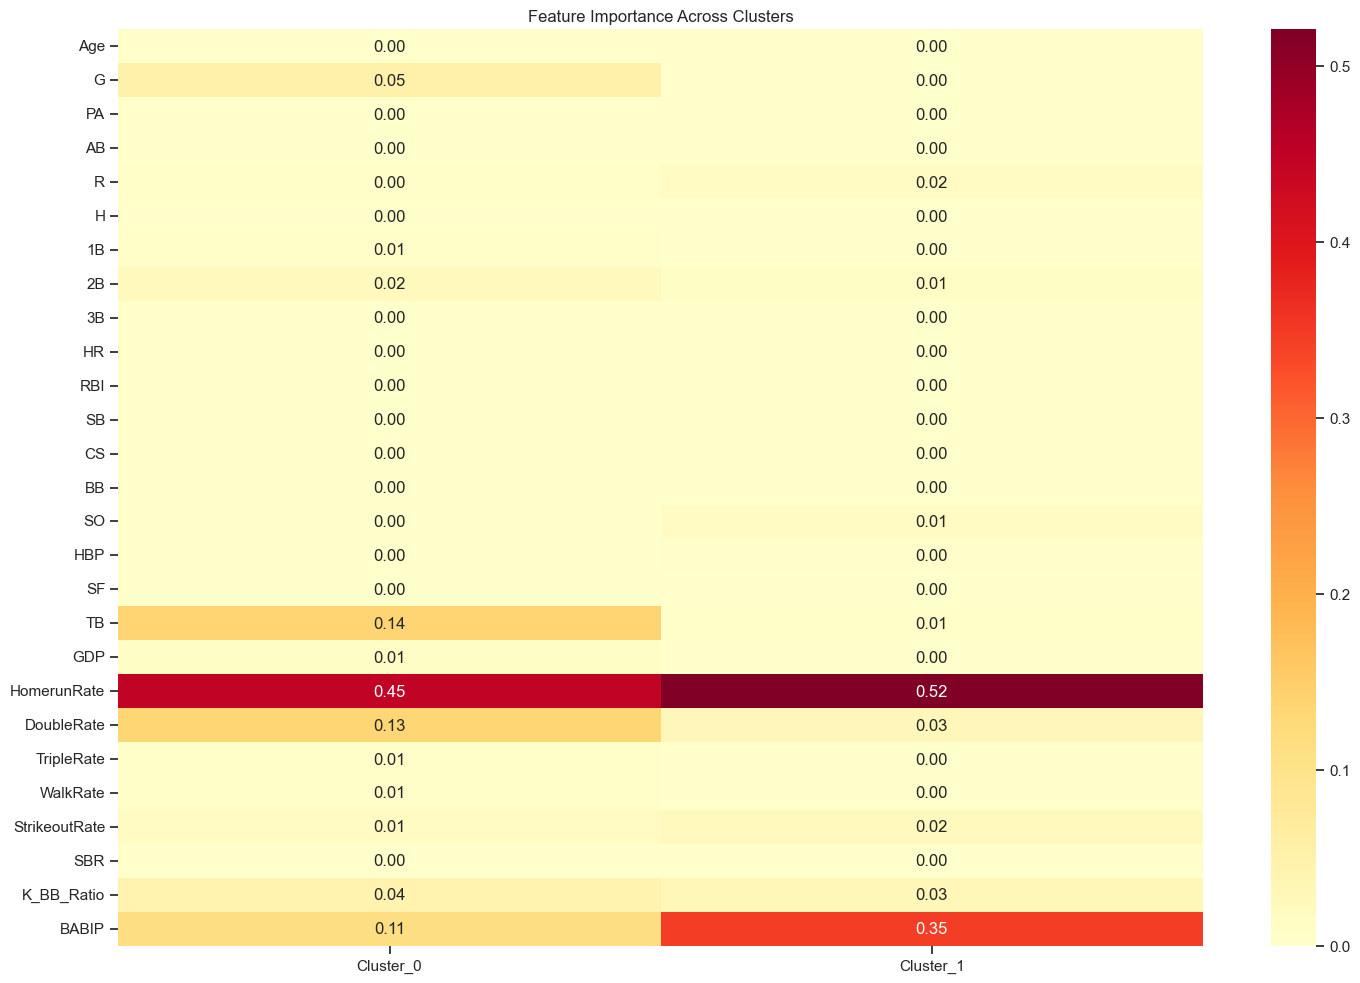

In [ ]:
all_importance = pd.DataFrame(
    index=cluster_features,
    columns=[f'Cluster_{i}' for i in range(n_clusters)]
)

for cluster in range(n_clusters):
    all_importance[f'Cluster_{cluster}'] = cluster_models[cluster].feature_importances_

plt.figure(figsize=(15, 10))
sns.heatmap(all_importance, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Feature Importance Across Clusters')
plt.tight_layout()
plt.show()

## For fun analysis

The following dataset that is being analyised only includes special batting statistics, we thought it would be fun to try and analyse very unique data to try and perdict OPS from very unique stats like speed of ball coming off bat.

In [ ]:
dfUnique = pd.read_csv("stats.csv", sep=',')
dfUnique.columns

#We could not use this dataset for the presentation since it has no need to be cleaned, it only uses players that qualify for the mlb statistics of playing a certain number of games and it ensures there are no nulls already
#however it will be very interesting to see the models predicting off of it

Index(['last_name, first_name', 'player_id', 'year', 'on_base_plus_slg', 'xba',
       'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon', 'xbadiff',
       'avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing',
       'squared_up_contact', 'squared_up_swing', 'avg_swing_length', 'swords',
       'attack_angle', 'attack_direction', 'ideal_angle_rate',
       'vertical_swing_path', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrel', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'avg_best_speed', 'avg_hyper_speed'],
      dtype='object')

In [ ]:
df = dfUnique 

exclude_cols = ['last_name, first_name', 'player_id', 'year', 'on_base_plus_slg']
features2 = [col for col in dfUnique.columns if col not in exclude_cols]

X = df[features2]
y = df['on_base_plus_slg']

In [ ]:
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42,
    'early_stopping_rounds': 100
}

eval_list = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    evals=eval_list,
    early_stopping_rounds=100,
    verbose_eval=True
)

[0]	train-rmse:0.06811	eval-rmse:0.10203
[1]	train-rmse:0.06307	eval-rmse:0.09897
[2]	train-rmse:0.05846	eval-rmse:0.09526
[3]	train-rmse:0.05421	eval-rmse:0.09179
[4]	train-rmse:0.05034	eval-rmse:0.08908
[5]	train-rmse:0.04684	eval-rmse:0.08633
[6]	train-rmse:0.04356	eval-rmse:0.08458
[7]	train-rmse:0.04050	eval-rmse:0.08240
[8]	train-rmse:0.03761	eval-rmse:0.08133
[9]	train-rmse:0.03497	eval-rmse:0.07991
[10]	train-rmse:0.03277	eval-rmse:0.07825
[11]	train-rmse:0.03066	eval-rmse:0.07663
[12]	train-rmse:0.02872	eval-rmse:0.07570
[13]	train-rmse:0.02704	eval-rmse:0.07509
[14]	train-rmse:0.02550	eval-rmse:0.07383
[15]	train-rmse:0.02394	eval-rmse:0.07315
[16]	train-rmse:0.02233	eval-rmse:0.07171
[17]	train-rmse:0.02095	eval-rmse:0.07138
[18]	train-rmse:0.01982	eval-rmse:0.07044
[19]	train-rmse:0.01852	eval-rmse:0.06942
[20]	train-rmse:0.01737	eval-rmse:0.06880
[21]	train-rmse:0.01638	eval-rmse:0.06846
[22]	train-rmse:0.01546	eval-rmse:0.06794
[23]	train-rmse:0.01460	eval-rmse:0.06723
[2

In [ ]:
y_pred = model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Model Performance Metrics:
R-squared (R2) Score: 0.6816
Root Mean Squared Error (RMSE): 0.0601
Mean Absolute Error (MAE): 0.0466


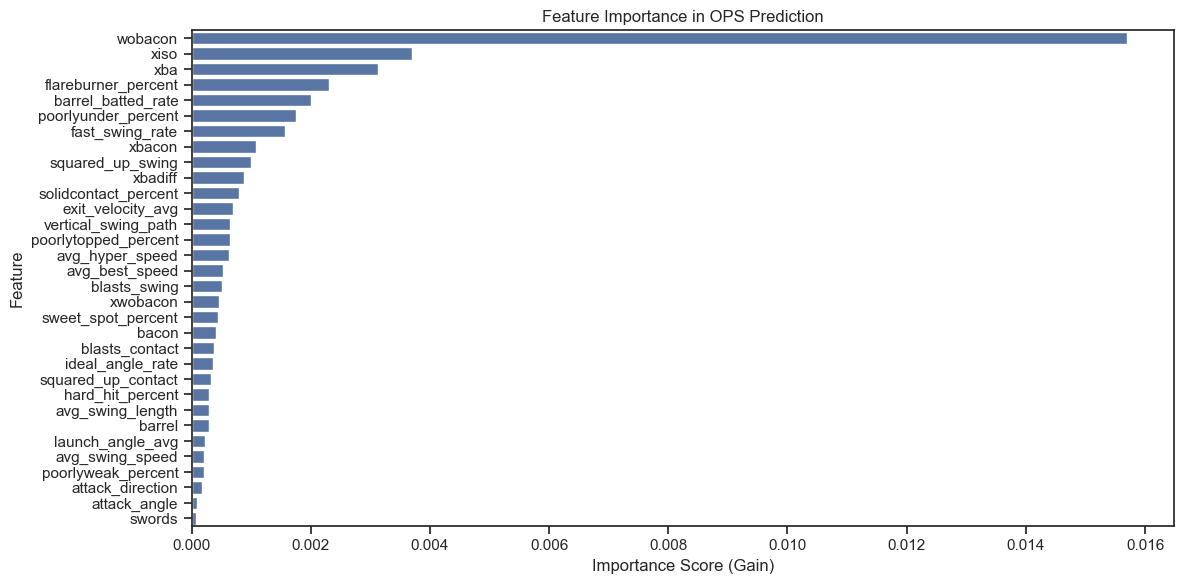

In [ ]:
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance': list(importance_scores.values())
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in OPS Prediction')
plt.xlabel('Importance Score (Gain)')
plt.tight_layout()
plt.show()

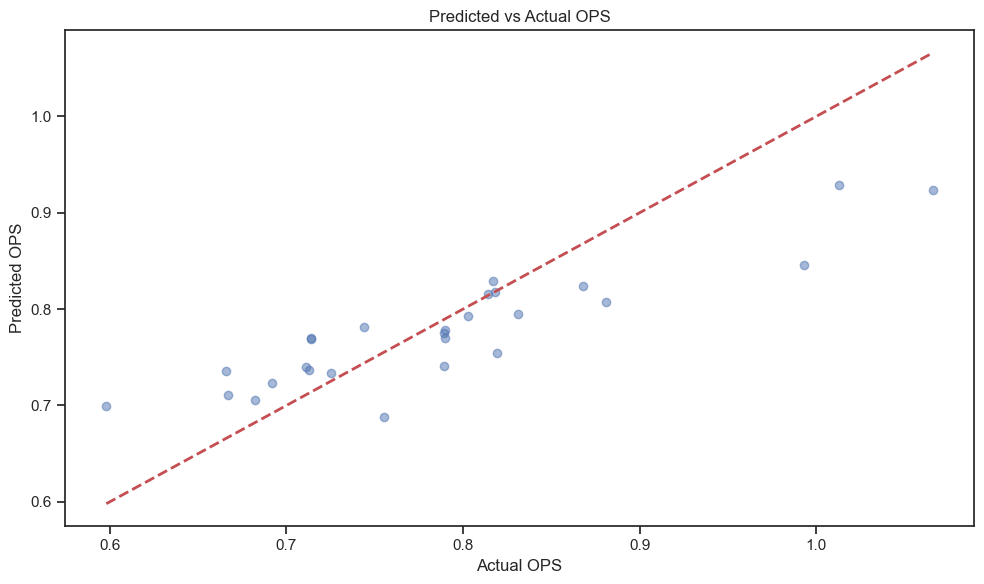

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual OPS')
plt.ylabel('Predicted OPS')
plt.title('Predicted vs Actual OPS')
plt.tight_layout()
plt.show()